In [9]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === PARAMETER ===
PROVINSI = "Jawa Tengah"
WINDOW_SIZE = 30
HORIZON = 7

# === LOAD & PIVOT ===
df = pd.read_csv("harga_beras_premium.csv")
df["Tanggal"] = pd.to_datetime(df["Tanggal"], dayfirst=True)
df_pivot = df.pivot(index="Tanggal", columns="Provinsi", values="Harga").sort_index()
df_pivot = df_pivot.fillna(method="ffill")

# === AMBIL 1 PROVINSI SAJA ===
df_prov = df_pivot[[PROVINSI]].dropna()

# === SPLIT ===
df_prov = df_prov.loc["2024-01-20":"2025-05-16"]
train_end = "2024-08-31"
val_end = "2025-01-31"

train_df = df_prov.loc[:train_end]
val_df = df_prov.loc[train_end:val_end].iloc[1:]
test_df = df_prov.loc[val_end:].iloc[1:]

# === SCALING ===
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

# === FUNGSI TENSOR ===
def create_tensor(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1])
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)  # 👈 fix: pastikan 2D, bukan (N,1,1)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

X_train, y_train = create_tensor(train_scaled, WINDOW_SIZE, HORIZON)
X_val, y_val = create_tensor(val_scaled, WINDOW_SIZE, HORIZON)
X_test, y_test = create_tensor(test_scaled, WINDOW_SIZE, HORIZON)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)


Train: torch.Size([188, 30, 1]) torch.Size([188, 1])
Val  : torch.Size([116, 30, 1]) torch.Size([116, 1])
Test : torch.Size([68, 30, 1]) torch.Size([68, 1])


/tmp/ipykernel_10597/1757277084.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pivot = df_pivot.fillna(method="ffill")


In [10]:
# Ambil nilai terakhir dari window sebagai baseline prediksi
baseline_pred = X_test[:, -1, 0].numpy()
true = y_test[:, 0].numpy()

# Inverse transform ke skala rupiah
baseline_pred_rp = scaler.inverse_transform(baseline_pred.reshape(-1, 1)).flatten()
true_rp = scaler.inverse_transform(true.reshape(-1, 1)).flatten()

# Evaluasi
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    r2 = r2_score(y_true, y_pred)
    return {"RMSE (Rp)": rmse, "MAE (Rp)": mae, "MAPE (%)": mape, "R²": r2}

baseline_result = evaluate(true_rp, baseline_pred_rp)
print("📊 Baseline Moving Average:")
for k, v in baseline_result.items():
    print(f"{k}: {v:,.2f}")


📊 Baseline Moving Average:
RMSE (Rp): 49.69
MAE (Rp): 40.01
MAPE (%): 0.27
R²: 0.25


In [11]:
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleLSTM(input_dim=1, hidden_dim=64, output_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(1, 51):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == 1:
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = loss_fn(val_pred, y_val)
        print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}")


Epoch 1: Train Loss = 0.9785, Val Loss = 0.7475
Epoch 10: Train Loss = 0.8177, Val Loss = 0.5953
Epoch 20: Train Loss = 0.6142, Val Loss = 0.4125
Epoch 30: Train Loss = 0.2043, Val Loss = 0.1115
Epoch 40: Train Loss = 0.1256, Val Loss = 0.0426
Epoch 50: Train Loss = 0.0804, Val Loss = 0.0508



📊 LSTM Model:
RMSE (Rp): 112.11
MAE (Rp): 99.96
MAPE (%): 0.68
R²: -2.83


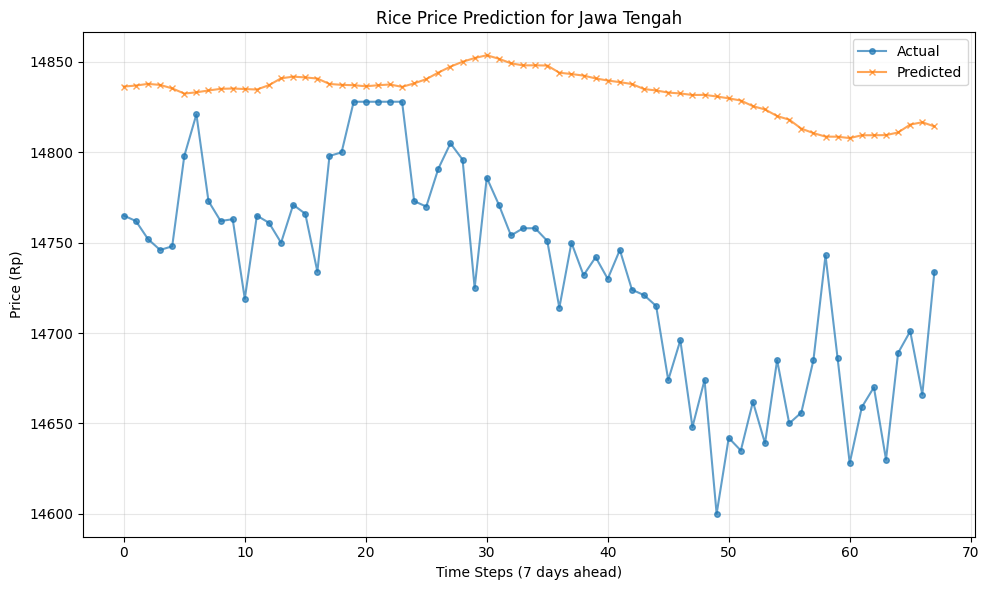

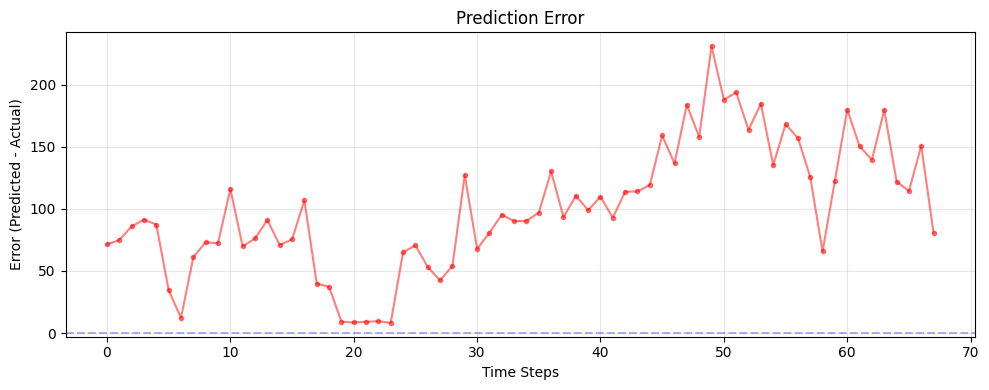

In [12]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test).cpu().numpy()

# Inverse transform hasil prediksi & target
y_pred_rp = scaler.inverse_transform(y_pred).flatten()

# Fix: reshape the tensor to 2D before inverse transforming
y_true_np = y_test.cpu().numpy().reshape(-1, 1)  # Reshape to [batch_size, 1]
y_true_rp = scaler.inverse_transform(y_true_np).flatten()

result_lstm = evaluate(y_true_rp, y_pred_rp)

print("\n📊 LSTM Model:")
for k, v in result_lstm.items():
    print(f"{k}: {v:,.2f}")

# Visualize predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_true_rp, label='Actual', marker='o', alpha=0.7, markersize=4)
plt.plot(y_pred_rp, label='Predicted', marker='x', alpha=0.7, markersize=4)
plt.title(f'Rice Price Prediction for {PROVINSI}')
plt.xlabel('Time Steps (7 days ahead)')
plt.ylabel('Price (Rp)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate error metrics for visualization
errors = y_pred_rp - y_true_rp
plt.figure(figsize=(10, 4))
plt.plot(errors, color='r', marker='o', linestyle='-', alpha=0.5, markersize=3)
plt.axhline(y=0, color='b', linestyle='--', alpha=0.3)
plt.title('Prediction Error')
plt.xlabel('Time Steps')
plt.ylabel('Error (Predicted - Actual)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()